In [1]:
# Image Steganography using LSB (Least Significant Bit) Technique
# A Python implementation for hiding and extracting text messages in images

# Import required libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# ========================================
# HELPER FUNCTIONS
# ========================================

def text_to_binary(text):
    """Convert text to binary representation"""
    binary = ''.join(format(ord(char), '08b') for char in text)
    return binary

def binary_to_text(binary):
    """Convert binary representation back to text"""
    text = ''
    for i in range(0, len(binary), 8):
        byte = binary[i:i+8]
        if len(byte) == 8:
            text += chr(int(byte, 2))
    return text

In [3]:
def generate_sample_image():
    """Generate a sample colorful image for demonstration"""
    # Create a 200x200 RGB image with gradient colors
    width, height = 200, 200
    image_array = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Create gradient pattern
    for i in range(height):
        for j in range(width):
            image_array[i, j] = [
                int((i / height) * 255),      # Red gradient
                int((j / width) * 255),       # Green gradient
                int(((i + j) / (height + width)) * 255)  # Blue gradient
            ]
    
    # Add some pattern to make it more interesting
    for i in range(0, height, 20):
        image_array[i:i+2, :] = [255, 255, 255]  # White horizontal lines
    
    return Image.fromarray(image_array)

In [4]:
# ========================================
# STEGANOGRAPHY CLASS
# ========================================

class ImageSteganography:
    
    def __init__(self):
        self.delimiter = "####END####"  # Delimiter to mark end of message
    
    def hide_message(self, image_path, message, output_path):
        """
        Hide a text message in an image using LSB steganography
        
        Args:
            image_path: Path to the input image
            message: Text message to hide
            output_path: Path to save the output image
        """
        try:
            # Open and convert image to RGB
            img = Image.open(image_path).convert('RGB')
            img_array = np.array(img)
            
            # Add delimiter to message to mark its end
            message_with_delimiter = message + self.delimiter
            
            # Convert message to binary
            binary_message = text_to_binary(message_with_delimiter)
            
            # Check if image can hold the message
            total_pixels = img_array.shape[0] * img_array.shape[1]
            max_bits = total_pixels * 3  # 3 color channels (RGB)
            
            if len(binary_message) > max_bits:
                raise ValueError("Message too long for this image!")
            
            print(f"Original message: '{message}'")
            print(f"Message length: {len(message)} characters")
            print(f"Binary length: {len(binary_message)} bits")
            print(f"Image capacity: {max_bits} bits")
            
            # Flatten the image array for easier processing
            flat_img = img_array.flatten()
            
            # Hide the message in LSBs
            for i, bit in enumerate(binary_message):
                # Modify the LSB of each pixel value
                flat_img[i] = (flat_img[i] & 0xFE) | int(bit)
            
            # Reshape back to original image shape
            modified_img_array = flat_img.reshape(img_array.shape)
            
            # Save the modified image
            modified_img = Image.fromarray(modified_img_array.astype(np.uint8))
            modified_img.save(output_path)
            
            print(f"Message successfully hidden in '{output_path}'")
            return True
            
        except Exception as e:
            print(f"Error hiding message: {e}")
            return False
    
    def extract_message(self, image_path):
        """
        Extract hidden message from an image
        
        Args:
            image_path: Path to the image containing hidden message
            
        Returns:
            Extracted message as string
        """
        try:
            # Open the image
            img = Image.open(image_path).convert('RGB')
            img_array = np.array(img)
            
            # Flatten the image array
            flat_img = img_array.flatten()
            
            # Extract LSBs to reconstruct the binary message
            binary_message = ''
            
            for pixel_value in flat_img:
                binary_message += str(pixel_value & 1)  # Get LSB
                
                # Check if we've found the delimiter
                if len(binary_message) >= len(text_to_binary(self.delimiter)):
                    # Convert current binary to text and check for delimiter
                    current_text = binary_to_text(binary_message)
                    if self.delimiter in current_text:
                        # Found delimiter, extract message without delimiter
                        message = current_text.split(self.delimiter)[0]
                        print(f"Extracted message: '{message}'")
                        return message
            
            print("No hidden message found or delimiter not detected")
            return None
            
        except Exception as e:
            print(f"Error extracting message: {e}")
            return None
    
    def compare_images(self, original_path, modified_path):
        """
        Compare original and modified images to show the difference
        """
        try:
            # Load images
            original = Image.open(original_path).convert('RGB')
            modified = Image.open(modified_path).convert('RGB')
            
            # Convert to numpy arrays
            orig_array = np.array(original)
            mod_array = np.array(modified)
            
            # Calculate difference
            difference = np.abs(orig_array.astype(int) - mod_array.astype(int))
            
            # Create visualization
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            axes[0, 0].imshow(original)
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(modified)
            axes[0, 1].set_title('Image with Hidden Message')
            axes[0, 1].axis('off')
            
            axes[1, 0].imshow(difference)
            axes[1, 0].set_title('Difference (Enhanced)')
            axes[1, 0].axis('off')
            
            # Statistics
            max_diff = np.max(difference)
            mean_diff = np.mean(difference)
            
            stats_text = f"""Difference Statistics:
                        Max difference: {max_diff}
                        Mean difference: {mean_diff:.4f}
                        Total pixels changed: {np.count_nonzero(difference)}
                    Percentage changed: {(np.count_nonzero(difference) / difference.size) * 100:.2f}%"""
            
            axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, 
                           verticalalignment='center', transform=axes[1, 1].transAxes)
            axes[1, 1].axis('off')
            axes[1, 1].set_title('Analysis')
            
            plt.tight_layout()
            plt.show()
            
            return max_diff, mean_diff
            
        except Exception as e:
            print(f"Error comparing images: {e}")
            return None, None

=== Creating Sample Image ===
Sample image created: 'sample_image.png'


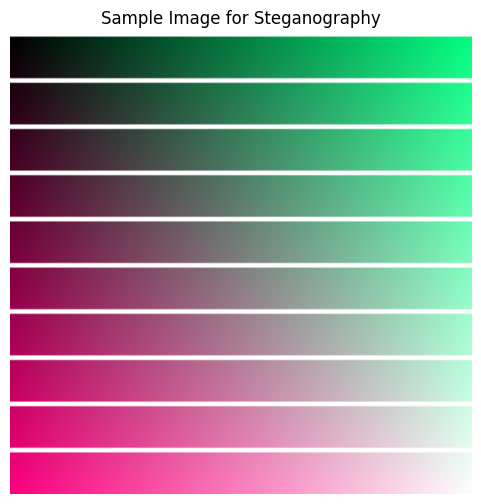

In [5]:
# ========================================
# DEMONSTRATION
# ========================================

# Create an instance of the steganography class
stego = ImageSteganography()

# Generate a sample image for demonstration
print("=== Creating Sample Image ===")
sample_img = generate_sample_image()
sample_img.save('sample_image.png')
print("Sample image created: 'sample_image.png'")

# Display the sample image
plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.title('Sample Image for Steganography')
plt.axis('off')
plt.show()

In [6]:
# ========================================
# HIDING A MESSAGE
# ========================================

print("\n=== Hiding Message in Image ===")
secret_message = "This is a confidential message hidden using steganography!"

# Hide the message
success = stego.hide_message('sample_image.png', secret_message, 'hidden_message_image.png')

if success:
    print("✓ Message hidden successfully!")
else:
    print("✗ Failed to hide message")


=== Hiding Message in Image ===
Original message: 'This is a confidential message hidden using steganography!'
Message length: 58 characters
Binary length: 552 bits
Image capacity: 120000 bits
Message successfully hidden in 'hidden_message_image.png'
✓ Message hidden successfully!


In [7]:
# ========================================
# EXTRACTING THE MESSAGE
# ========================================

print("\n=== Extracting Hidden Message ===")
extracted_message = stego.extract_message('hidden_message_image.png')

if extracted_message:
    print(f"✓ Message extraction successful!")
    print(f"Original message: '{secret_message}'")
    print(f"Extracted message: '{extracted_message}'")
    print(f"Messages match: {secret_message == extracted_message}")
else:
    print("✗ Failed to extract message")


=== Extracting Hidden Message ===
Extracted message: 'This is a confidential message hidden using steganography!'
✓ Message extraction successful!
Original message: 'This is a confidential message hidden using steganography!'
Extracted message: 'This is a confidential message hidden using steganography!'
Messages match: True



=== Comparing Original and Modified Images ===


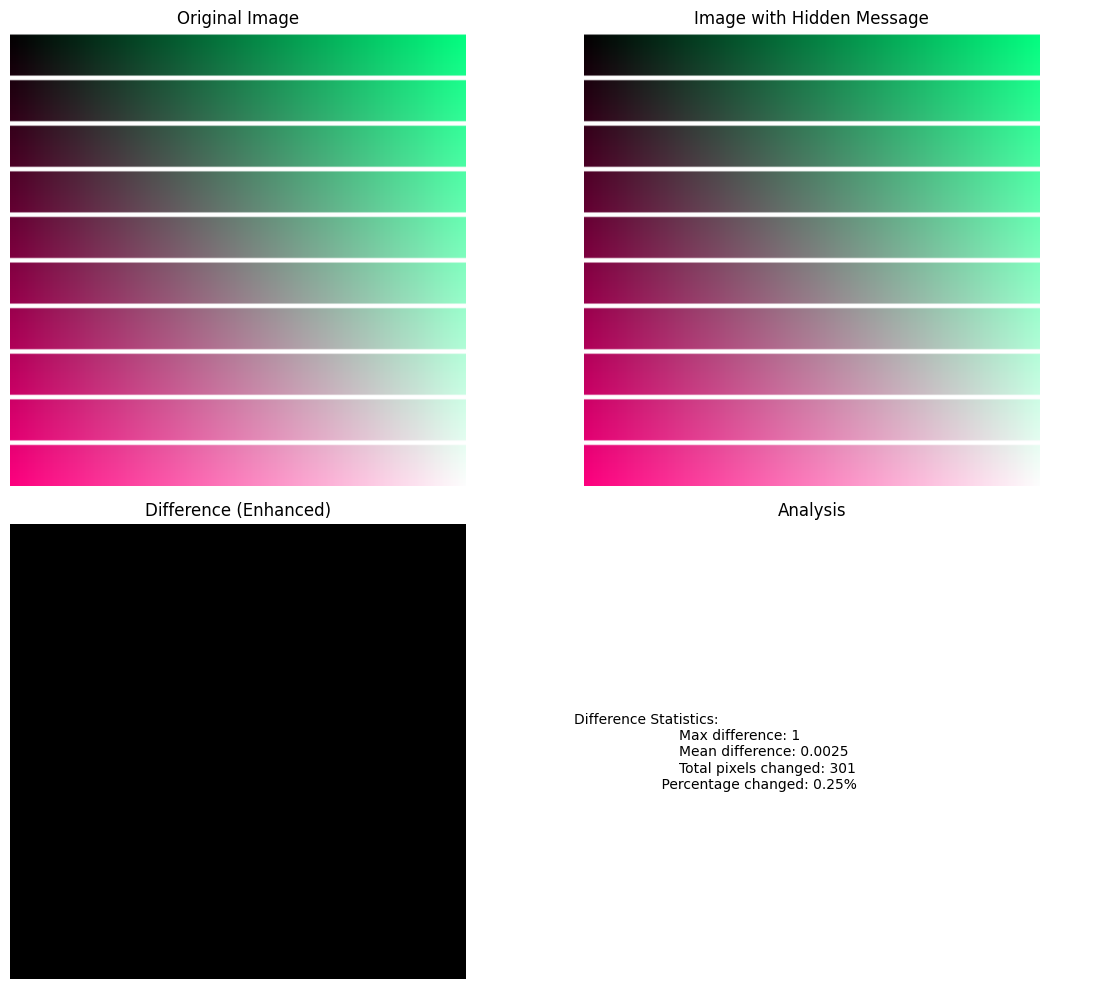

In [8]:
# ========================================
# VISUAL COMPARISON
# ========================================

print("\n=== Comparing Original and Modified Images ===")
max_diff, mean_diff = stego.compare_images('sample_image.png', 'hidden_message_image.png')

In [9]:
# ========================================
# TESTING WITH DIFFERENT MESSAGES
# ========================================

print("\n=== Testing with Different Message Lengths ===")

test_messages = [
    "Short",
    "This is a medium length message for testing purposes.",
    "This is a much longer message that contains more text to test the capacity and reliability of our steganography implementation. It includes various characters and symbols to ensure robust encoding and decoding!"
]

for i, msg in enumerate(test_messages):
    print(f"\nTest {i+1}: Message length = {len(msg)} characters")
    
    # Hide message
    output_file = f'test_image_{i+1}.png'
    if stego.hide_message('sample_image.png', msg, output_file):
        # Extract message
        extracted = stego.extract_message(output_file)
        if extracted == msg:
            print(f"✓ Test {i+1} PASSED")
        else:
            print(f"✗ Test {i+1} FAILED")
    else:
        print(f"✗ Test {i+1} FAILED - Could not hide message")



=== Testing with Different Message Lengths ===

Test 1: Message length = 5 characters
Original message: 'Short'
Message length: 5 characters
Binary length: 128 bits
Image capacity: 120000 bits
Message successfully hidden in 'test_image_1.png'
Extracted message: 'Short'
✓ Test 1 PASSED

Test 2: Message length = 53 characters
Original message: 'This is a medium length message for testing purposes.'
Message length: 53 characters
Binary length: 512 bits
Image capacity: 120000 bits
Message successfully hidden in 'test_image_2.png'
Extracted message: 'This is a medium length message for testing purposes.'
✓ Test 2 PASSED

Test 3: Message length = 210 characters
Original message: 'This is a much longer message that contains more text to test the capacity and reliability of our steganography implementation. It includes various characters and symbols to ensure robust encoding and decoding!'
Message length: 210 characters
Binary length: 1768 bits
Image capacity: 120000 bits
Message successfully

In [10]:
# ========================================
# SECURITY ANALYSIS
# ========================================

print("\n=== Security Analysis ===")
print("""
STEGANOGRAPHY SECURITY FEATURES:
1. Visual Imperceptibility: Changes are made only to LSBs, making them invisible to human eye
2. No Size Change: The image file size remains virtually the same
3. Format Preservation: The image format and metadata are preserved
4. Statistical Resistance: LSB changes follow natural image noise patterns

POTENTIAL VULNERABILITIES:
1. Statistical Analysis: Advanced steganalysis can detect LSB patterns
2. Sequential Embedding: Messages are embedded sequentially, creating patterns
3. No Encryption: The hidden message is not encrypted, only hidden
4. Delimiter Dependency: Uses a fixed delimiter that could be detected

IMPROVEMENTS FOR PRODUCTION USE:
1. Add encryption before hiding the message
2. Use random pixel selection instead of sequential
3. Implement adaptive LSB based on image characteristics
4. Add compression to reduce message size
5. Use dynamic delimiters or length prefixes
""")

print("\n=== Demonstration Complete ===")
print("Files created:")
print("- sample_image.png (original)")
print("- hidden_message_image.png (with hidden message)")
print("- test_image_1.png, test_image_2.png, test_image_3.png (test files)")


=== Security Analysis ===

STEGANOGRAPHY SECURITY FEATURES:
1. Visual Imperceptibility: Changes are made only to LSBs, making them invisible to human eye
2. No Size Change: The image file size remains virtually the same
3. Format Preservation: The image format and metadata are preserved
4. Statistical Resistance: LSB changes follow natural image noise patterns

POTENTIAL VULNERABILITIES:
1. Statistical Analysis: Advanced steganalysis can detect LSB patterns
2. Sequential Embedding: Messages are embedded sequentially, creating patterns
3. No Encryption: The hidden message is not encrypted, only hidden
4. Delimiter Dependency: Uses a fixed delimiter that could be detected

IMPROVEMENTS FOR PRODUCTION USE:
1. Add encryption before hiding the message
2. Use random pixel selection instead of sequential
3. Implement adaptive LSB based on image characteristics
4. Add compression to reduce message size
5. Use dynamic delimiters or length prefixes


=== Demonstration Complete ===
Files created